In [68]:
# Programmer Name: Ms Lee Wen Xi, APD3F2211CS(IS)
# Program Name: Sentiment_Model_SVM.ipynb
# Description: A script to train the sentiment prediction model withn SVM
# First Written On: 26/05/2023
# Last Edited On:  22/07/2023

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import nltk
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import joblib
import re
import string

In [2]:
# Preprocessing
nltk_stop_words = set(stopwords.words('english'))
punc = list(string.punctuation) + list('‘’')
stop_words = []

# Negation Lexicon
negations = ['aint', 'doesnt', 'havent', 'lacks', 'none', 'mightnt', 'shouldnt', 'cannot', 'dont', 'havnt', 'neither', 'nor', 'mustnt', 'wasnt', 'cant', 'hadnt', 'isnt', 'never', 'not', 'neednt', 'without', 'darent' 'hardly', 'lack', 'no', 'nothing', 'oughtnt', 'wouldnt', 'didnt', 'hasnt', 'lacking', 'nobody', 'nowhere', 'shant', 'ain', 'doesn', 'haven', 'mightn', 'shouldn', 'havn', 'mustn', 'wasn', 'hadn', 'isn', 'needn', 'oughtn', 'wouldn', 'didn', 'hasn', 'shan', 'couldn', 'won', 'don', 'aren', 'arent', 'weren', 'werent' 'against']
rneg = r"[A-Za-z]{1,}n't\b"

# Remove the negation from the nltk stop words
for w in nltk_stop_words:
    if not w in negations and not re.match(rneg, w):
        stop_words.append(w)

# remove emojis and chinese characters
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

# remove noises such as tags, URLs and emojis
def remove_tags(string):
    result = re.sub(r'@[A-Za-z0-9]{0,}(\s|\b)', '', string)   #remove @ tags
    result = re.sub(r'#[A-Za-z0-9]{0,}(\s|\b)', '', result)   #remove # tags
    result = re.sub(r'\b((http|https):\/\/)[-a-zA-Z0-9@:%._\\+~#?&\/\/=]{0,}','',result)   #remove URLs
    result = remove_emojis(result)    # remove emojis
    result = result.lower()
    
    return result

['to', 'at', 'my', 'if', 'most', 'will', 'is', 'an', "should've", 'into', 'do', 'few', 'same', 'of', 'being', 'we', "it's", 'where', 'but', 'for', 'with', 'm', 'between', 'and', 'only', 'just', 'when', 'its', 'they', 'had', 'very', 'too', 'below', "that'll", 'during', 'each', 's', 'does', 'these', 'off', 'against', 'll', 'why', 'his', 'him', 'himself', 'how', 'am', 'here', 'ourselves', 'after', 'about', 'the', 're', "you'd", 'because', 'further', 'as', 'than', 'from', 'again', 'so', "you've", 'that', 'until', 'yourselves', 'under', 'through', 'her', 'it', 'down', 'were', 'before', 'them', 'o', 'themselves', 'you', 'yourself', 'he', "you'll", 'over', 't', 'more', 'such', 'theirs', 'been', 'those', 'own', 'whom', 'some', 'has', "she's", 'yours', 'then', 'above', 'i', 'doing', 'she', 'did', 'this', 'what', 'now', 'y', 'in', 'ma', 'all', 'ours', 'hers', 'a', 'which', 'on', 'any', 'who', 'both', "you're", 'once', 'me', 'should', 'can', 'other', 'by', 'herself', 'having', 'there', 'd', 'have

In [3]:
# Twitter Sentiment Dataset
data = pd.read_csv('Datasets\\Twitter Sentiment Dataset\\Twitter_Data.csv')
data = data.dropna()
data = data.sample(frac = 1)

data['clean_text'] = data['clean_text'].apply(lambda cw : remove_tags(cw)) 
data['clean_text'] = data['clean_text'].apply(lambda x: x.replace('"', ''))
data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in (punc)]))
data['clean_text'] = data['clean_text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word not in (stop_words)]))
data['clean_text'] = data['clean_text'].apply(lambda x: re.sub('\W+',' ',x).strip())
data['clean_text'] = data['clean_text'].str.strip()

In [4]:
# Split into test and train data
tweet = data['clean_text'].values
labels = data['category'].astype('int').values
train_sentences, test_sentences, train_labels, test_labels = train_test_split(tweet, labels, stratify = labels)

# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
train_vectors = vectorizer.fit_transform(train_sentences)
test_vectors = vectorizer.transform(test_sentences)

In [6]:
# Perform classification with SVM
classifier_linear = svm.SVC(kernel='linear')
classifier_linear.fit(train_vectors, train_labels)
prediction_linear = classifier_linear.predict(test_vectors)

positive:  {'precision': 0.9323290979129535, 'recall': 0.8977467751757737, 'f1-score': 0.9147111913357402, 'support': 18063}
neutral:  {'precision': 0.8951687624090007, 'recall': 0.9799318988625662, 'f1-score': 0.9356344896759243, 'support': 13803}
negative:  {'precision': 0.8807038834951456, 'recall': 0.8175059141601893, 'f1-score': 0.8479289595139334, 'support': 8877}


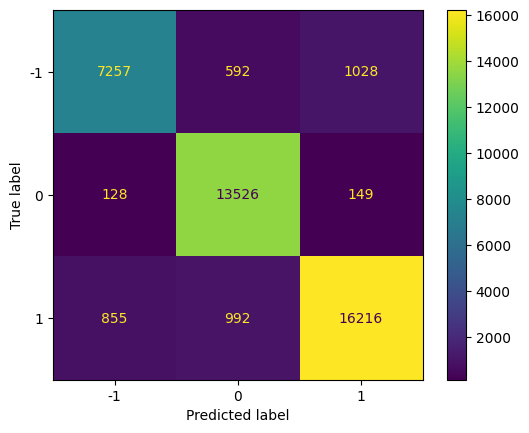

In [22]:
# results
report = classification_report(test_labels, prediction_linear, output_dict=True)
print('positive: ', report['1'])
print('neutral: ', report['0'])
print('negative: ', report['-1'])

cm = confusion_matrix(test_labels, prediction_linear)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier_linear.classes_)
disp.plot()
plt.show()

In [ ]:
# Export vectorizer and model
joblib.dump(vectorizer, 'vectorizer.pkl')
joblib.dump(classifier_linear, 'SVM_Sentiment.joblib')